# 하이브리드 추천방식 활용
1. KMeans로 군집화
2. 군집 내에서 가장 유사한 10명의 유저 추출 (Cosine 유사도)

## 0.라이브러리

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

## 1. 데이터 로드 & 전처리 컬럼 설정

In [3]:
df = pd.read_csv('../data/VL_CSV/tn_traveller_master_여행객 Master_E.csv')

In [4]:
df.drop('JOB_ETC', axis=1, inplace=True)

In [5]:
df['GENDER'] = df['GENDER'].map({'남': 1, '여': 2})

In [6]:
df.head().T

,0,1,2,3,4
TRAVELER_ID,e004720,e000914,e003564,e000396,e001890
RESIDENCE_SGG_CD,41,30,41,41,11
GENDER,2,2,2,2,1
AGE_GRP,60,20,30,30,20
EDU_NM,4,6,7,6,6
EDU_FNSH_SE,1.0,1.0,1.0,1.0,1.0
MARR_STTS,3,1,2,2,1
FAMILY_MEMB,3,1,4,2,4
JOB_NM,11,3,2,2,3
INCOME,4,4,7,2,5


In [7]:
# 사용할 컬럼 정의
categorical_cols = [
    'GENDER', 'EDU_NM', 'EDU_FNSH_SE', 'MARR_STTS', 'JOB_NM',
    'HOUSE_INCOME', 'TRAVEL_TERM',
    'TRAVEL_LIKE_SIDO_1', 'TRAVEL_LIKE_SIDO_2', 'TRAVEL_LIKE_SIDO_3',
]

numerical_cols = [
    'AGE_GRP', 'FAMILY_MEMB', 'TRAVEL_NUM', 'TRAVEL_COMPANIONS_NUM',
    'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3', 'TRAVEL_STYL_4',
    'TRAVEL_STYL_5', 'TRAVEL_STYL_6', 'TRAVEL_STYL_7', 'TRAVEL_STYL_8',
    'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2',
    'INCOME'
]

use_cols = categorical_cols + numerical_cols

# 전처리용 데이터 필터링 (결측치 제거)
df_filtered = df[use_cols].dropna()

| 구분            | 포함 컬럼                                                          | 설명              |
| ------------- | -------------------------------------------------------------- | --------------- |
| **기본 정보**     | `AGE_GRP`, `GENDER`, `FAMILY_MEMB`                             | 나이/성별/가족구성      |
| **여행 특성**     | `TRAVEL_NUM`, `TRAVEL_TERM`, `TRAVEL_COMPANIONS_NUM`           | 빈도, 기간, 동반자 수 등 |
| **경제/사회적 정보** | `INCOME`, `HOUSE_INCOME`, `JOB_NM`, `EDU_NM`, `MARR_STTS`      | 다양한 사회적 변수들     |
| **여행 선호**     | `TRAVEL_LIKE_SIDO_1~3`, `TRAVEL_STYL_1~8`, `TRAVEL_MOTIVE_1~2` | 성향 기반 feature   |


In [8]:
df_filtered.head(3).T

,0,2,3
GENDER,2.0,2.0,2.0
EDU_NM,4.0,7.0,6.0
EDU_FNSH_SE,1.0,1.0,1.0
MARR_STTS,3.0,2.0,2.0
JOB_NM,11.0,2.0,2.0
HOUSE_INCOME,9.0,12.0,5.0
TRAVEL_TERM,2.0,2.0,2.0
TRAVEL_LIKE_SIDO_1,11.0,42.0,50.0
TRAVEL_LIKE_SIDO_2,47.0,48.0,42.0
TRAVEL_LIKE_SIDO_3,41.0,41.0,44.0


In [10]:
df[use_cols + ['TRAVELER_ID']].dropna().to_csv('../data/VL_csv/tn_traveller_master_여행객 Master_E_preprocessed.csv', index=False)

In [177]:
df_filtered.shape, df.shape

((1919, 25), (2560, 35))

## 2. 전처리 및 군집화 파이프라인 작성

In [178]:
# 전처리 파이프라인
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])

# 클러스터링 포함 파이프라인 (8개 클러스터 기준)
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('cluster', KMeans(n_clusters=8, random_state=42))
])

# 학습
pipeline.fit(df_filtered)

# 클러스터 결과 저장
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

## 3. 군집 내 유사 유저 추출

In [179]:
# 원본 데이터에서 전처리 후 유저 ID 등 다시 붙이기 위해 인덱스 저장
df_with_id = df.copy()
df_filtered = df[use_cols].dropna()
df_filtered['cluster'] = pipeline.named_steps['cluster'].labels_

# cluster index를 활용해 원본 데이터 반환
def recommend_similar_users_in_cluster(user_data: dict, top_n: int = 10):
    input_df = pd.DataFrame([user_data])[use_cols]
    input_vec = pipeline.named_steps['preprocess'].transform(input_df)
    
    # 클러스터 예측
    predicted_cluster = pipeline.named_steps['cluster'].predict(input_vec)[0]

    # 해당 클러스터 내 유저 추출 (index 기준)
    cluster_indices = df_filtered[df_filtered['cluster'] == predicted_cluster].index
    cluster_users = df_with_id.loc[cluster_indices] 

    # 전처리 벡터로 유사도 계산
    cluster_vecs = pipeline.named_steps['preprocess'].transform(df_filtered.loc[cluster_indices][use_cols])
    sim_scores = cosine_similarity(input_vec, cluster_vecs)[0]
    top_indices = np.argsort(sim_scores)[::-1][:top_n]

    return cluster_users.iloc[top_indices].copy()


## 4. 테스트

In [180]:
example_user = {
    'GENDER': '여',
    'EDU_NM': 4,
    'EDU_FNSH_SE': 1,
    'MARR_STTS': 3,
    'JOB_NM': 11,
    'INCOME': 4,
    'HOUSE_INCOME': 9,
    'TRAVEL_TERM': 2,
    'TRAVEL_LIKE_SIDO_1': 11,
    'TRAVEL_LIKE_SIDO_2': 47,
    'TRAVEL_LIKE_SIDO_3': 41,
    'TRAVEL_STYL_1': 2,
    'TRAVEL_STYL_2': 4,
    'TRAVEL_STYL_3': 4,
    'TRAVEL_STYL_4': 4,
    'TRAVEL_STYL_5': 4,
    'TRAVEL_STYL_6': 4,
    'TRAVEL_STYL_7': 5,
    'TRAVEL_STYL_8': 5,
    'TRAVEL_MOTIVE_1': 2,
    'TRAVEL_MOTIVE_2': 6,
    'AGE_GRP': 20,
    'FAMILY_MEMB': 3,
    'TRAVEL_NUM': 2,
    'TRAVEL_COMPANIONS_NUM': 1
}

top_users = recommend_similar_users_in_cluster(example_user, top_n=10)

# 확인
print(top_users[['TRAVELER_ID', 'AGE_GRP', 'TRAVEL_STATUS_DESTINATION']])


     TRAVELER_ID  AGE_GRP TRAVEL_STATUS_DESTINATION
74       e004655       30                        서울
2444     e008489       30                        경기
2481     e006028       20                        서울
851      e012070       20                        서울
972      e002402       30                        서울
1370     e002536       20                        서울
1771     e004338       30                        서울
241      e010222       20                        서울
729      e007753       40                        경기
156      e002784       20                        서울


- 유사도 높은 유저의 ID가 나오므로, 방문했던 여행지를 찾아낼 수 있음

In [181]:
travel = pd.read_csv('../data/VL_CSV/tn_travel_여행_E.csv')
area = pd.read_csv('../data/VL_CSV/tn_visit_area_info_방문지정보_E.csv')

In [182]:
travel = travel[travel['TRAVELER_ID'].isin(top_users['TRAVELER_ID'])]
len(travel)

10

In [183]:
travel_ids = travel['TRAVEL_ID'].to_list()
filter_area = ['집', '사무실', '학교', '기타']
area = area[(area['TRAVEL_ID'].isin(travel_ids)) & (~area['VISIT_AREA_NM'].isin(filter_area))]
len(area)

61

In [184]:
area['VISIT_AREA_NM'][:20]

6235               진명스포아트
6236    브루클린 더 버거 조인트 이촌점
6237              국립중앙박물관
6549              친구 친지 집
6550                  오송역
6551                 아이시티
6552           인왕산 수성동 계곡
6553              인왕산 둘레길
6554            더 숲 초소 책방
6555            인왕산 숲속 쉼터
6556             청운 문학도서관
6557         코비 브라이트 광화문점
6558                  덕수궁
6559                 아이시티
6560             오토 김밥 본점
6561                  소월길
6562               컴포트 서울
6563              경복궁 경회루
6564                  서울역
6565                 조치원역
Name: VISIT_AREA_NM, dtype: object

**추천 시스템에서 아래의 정보는 제거해야됨**

- 방문지 정보 데이터의 이름을 모두 전처리해야 될 것
    - 역, 주유소, 휴게소 - **주유소와 역은 이동수단과 관련된 정보임**
    - 숙소 정보 - **숙소 추천은 나중에 따로**

**TODO : 각 지역에 맞는 사진 불러오는 것 알고리즘 개발 필요**

## 5. 군집 시각화

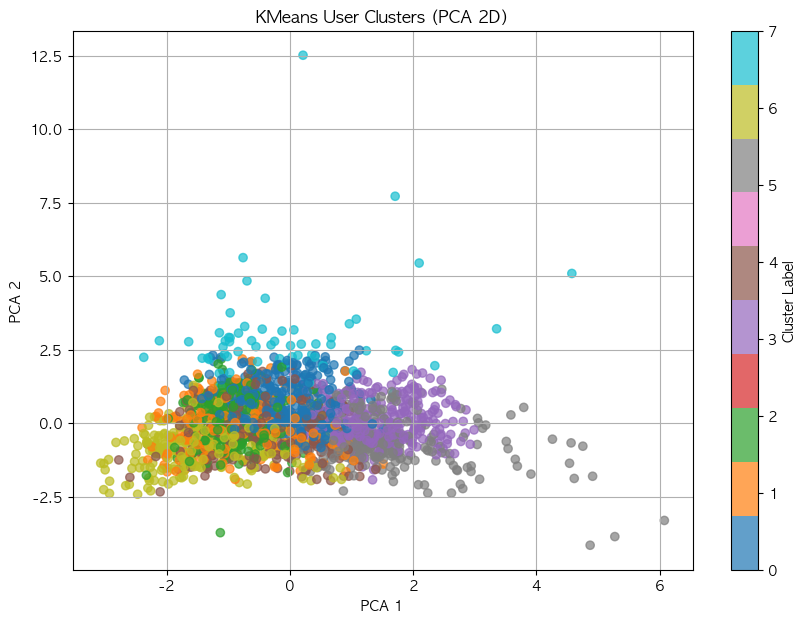

In [185]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X_all = pipeline.named_steps['preprocess'].transform(df_filtered[use_cols])
cluster_labels = df_filtered['cluster'].values

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)

plt.title("KMeans User Clusters (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster Label")
plt.grid(True)
plt.show()

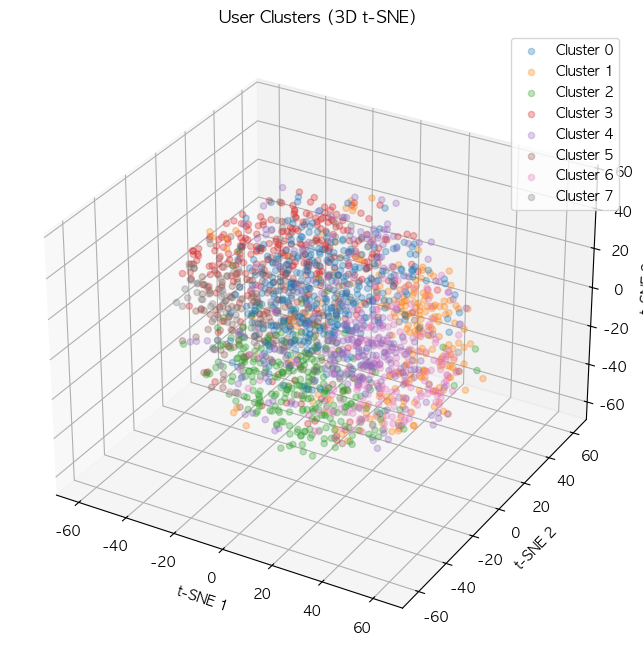

In [186]:
import seaborn as sns
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30, learning_rate=200, random_state=42)
colors = sns.color_palette('tab10', len(np.unique(cluster_labels)))
X_tsne = tsne.fit_transform(X_all)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(np.unique(cluster_labels)):
    cluster_points = X_tsne[cluster_labels == label]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[colors[i]], label=f'Cluster {label}', alpha=0.3)

ax.set_title("User Clusters (3D t-SNE)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_zlabel("t-SNE 3")
ax.legend()
plt.show()


# FAISS을 통한 거리 계산

- 군집 시각화가 어려움
- Kmeans와 같은 알고리즘의 특성상, 새로운 유저가 들어오면 기존 유저들과의 관계가 달라질 수 있음
    - 유저 수가 적으면, 그냥 kmeans를 사용해도 되는데, 많은 인원이 들어오게 된다면 사용하기 어려울 것이라고 판단
- FAISS 기반으로 l2-norm을 빠르게 계산하고 가까운 topk 유저 추출

In [187]:
import faiss
import numpy as np
import pandas as pd

In [188]:
user_df = pd.DataFrame([example_user])
input_vec = pipeline.named_steps['preprocess'].transform(user_df)

In [189]:
input_vec.shape

(1, 143)

In [190]:
# X_all: 모든 사용자 벡터 (n_users, n_features)
# input_vec: 추천 대상 사용자 벡터 (1, n_features)

# float32로 변환
X_all = X_all.astype('float32')
input_vec = input_vec.astype('float32')

# Index 생성 (IndexFlatL2)
d = X_all.shape[1]  # feature 수
index = faiss.IndexFlatL2(d)  # L2 거리 기반

# 인덱스에 전체 유저 벡터 추가
index.add(X_all)

# 유사 유저 top 10 검색
k = 10
D, I = index.search(input_vec, k)  # D: 거리, I: 인덱스

# 결과 출력
print("Top 10 유사 유저 인덱스:", I[0])
print("Top 10 거리:", D[0])

# 유사 유저 정보 확인
similar_users = df.iloc[I[0]]
print(similar_users[['TRAVELER_ID', 'AGE_GRP', 'TRAVEL_STATUS_DESTINATION']])


Top 10 유사 유저 인덱스: [   0   55 1012  561 1829  727  645 1857  977  293]
Top 10 거리: [10.918968 18.05421  21.852972 22.025671 23.497498 24.224176 24.685297
 24.775225 25.116026 25.216717]
     TRAVELER_ID  AGE_GRP TRAVEL_STATUS_DESTINATION
0        e004720       60                        서울
55       e010740       20                        서울
1012     e006414       40                        서울
561      e002584       30                        경기
1829     e003231       30                        경기
727      e000546       20                        서울
645      e000492       50                        경기
1857     e007342       20                        경기
977      e004668       30                        경기
293      e007512       20                        경기


In [191]:
travel = pd.read_csv('../data/VL_CSV/tn_travel_여행_E.csv')
area = pd.read_csv('../data/VL_CSV/tn_visit_area_info_방문지정보_E.csv')

In [192]:
travel = travel[travel['TRAVELER_ID'].isin(similar_users['TRAVELER_ID'])]
len(travel)

10

In [193]:
travel_ids = travel['TRAVEL_ID'].to_list()
filter_area = ['집', '사무실', '학교', '기타']
area = area[(area['TRAVEL_ID'].isin(travel_ids)) & (~area['VISIT_AREA_NM'].isin(filter_area))]
len(area)

54

In [194]:
area['VISIT_AREA_NM'][:20]

1077                  스카이랜드
1078     아웃백 스테이크하우스 부천 상동점
1079           상무 초밥 부천 상동점
1235               사마르칸트 본점
1236            백석예술대학교 예술도
1237              홈플러스 동대문점
1238    서울 동대문구 제기동 1140-41
1239             애니 오케이션 카페
1240    서울 동대문구 제기동 1140-41
1241             본 스테이크 신당점
1242    서울 동대문구 재기동 1140-41
1243                  지로 라멘
1244                    터라비
1245      꿈마을 우성아파트 25동 51호
6766                 블룸 비스타
6767               양수리 전통시장
6768                   두물머리
6769                 블룸 비스타
6770              솔향 장어 전문점
6772               양평곤충 박물관
Name: VISIT_AREA_NM, dtype: object

In [195]:
area.head(10).T

,1077,1078,1079,1235,1236,1237,1238,1239,1240,1241
VISIT_AREA_ID,2305290002,2305290003,2305290004,2305260002,2305260003,2305260004,2305260005,2305270001,2305270002,2305280001
TRAVEL_ID,e_e000492,e_e000492,e_e000492,e_e000546,e_e000546,e_e000546,e_e000546,e_e000546,e_e000546,e_e000546
VISIT_ORDER,2,3,4,2,3,4,5,6,7,8
VISIT_AREA_NM,스카이랜드,아웃백 스테이크하우스 부천 상동점,상무 초밥 부천 상동점,사마르칸트 본점,백석예술대학교 예술도,홈플러스 동대문점,서울 동대문구 제기동 1140-41,애니 오케이션 카페,서울 동대문구 제기동 1140-41,본 스테이크 신당점
VISIT_START_YMD,2023-05-29,2023-05-29,2023-05-29,2023-05-26,2023-05-26,2023-05-26,2023-05-26,2023-05-27,2023-05-27,2023-05-28
VISIT_END_YMD,2023-05-29,2023-05-29,2023-05-29,2023-05-26,2023-05-26,2023-05-26,2023-05-27,2023-05-27,2023-05-28,2023-05-28
ROAD_NM_ADDR,경기 부천시 상동로 90,경기 부천시 길주로 111,경기 부천시 길주로 111,NaN,서울 서초구 방배로9길 23,천호대로 133,NaN,서울 강남구 도산대로51길 14,NaN,서울 중구 동호로12길 59
LOTNO_ADDR,경기 부천시 상동 541-1,경기 부천시 상동 535-8,경기 부천시 상동 535-8,NaN,서울 서초구 방배동 981-7,NaN,NaN,서울 강남구 신사동 654-12,NaN,서울 중구 신당동 379-3
X_COORD,126.753932,126.754909,126.754852,NaN,126.99631,NaN,NaN,127.038067,NaN,127.011544
Y_COORD,37.505185,37.506473,37.506154,NaN,37.480209,NaN,NaN,37.52405,NaN,37.557825


In [196]:
photo = pd.read_csv('../data/VL_csv/tn_tour_photo_관광사진_E.csv')

In [197]:
pd.merge(
    area,
    photo,
    how='left',
    left_on=['TRAVEL_ID', 'VISIT_AREA_ID'],
    right_on=['TRAVEL_ID', 'VISIT_AREA_ID']
).dropna(subset=['POI_ID', 'PHOTO_FILE_ID']).drop_duplicates(subset='POI_ID').head(10).T

,1,2,5,8,15,16,19,22,23,26
VISIT_AREA_ID,2305290003,2305290004,2305260003,2305270001,2306100002,2306100003,2306100004,2306100006,2306110002,2306170003
TRAVEL_ID,e_e000492,e_e000492,e_e000546,e_e000546,e_e002584,e_e002584,e_e002584,e_e002584,e_e002584,e_e003231
VISIT_ORDER,3,4,3,6,6,2,3,5,7,2
VISIT_AREA_NM_x,아웃백 스테이크하우스 부천 상동점,상무 초밥 부천 상동점,백석예술대학교 예술도,애니 오케이션 카페,블룸 비스타,양수리 전통시장,두물머리,솔향 장어 전문점,양평곤충 박물관,파주 프리미엄 아울렛
VISIT_START_YMD,2023-05-29,2023-05-29,2023-05-26,2023-05-27,2023-06-10,2023-06-10,2023-06-10,2023-06-10,2023-06-11,2023-06-17
VISIT_END_YMD,2023-05-29,2023-05-29,2023-05-26,2023-05-27,2023-06-11,2023-06-10,2023-06-10,2023-06-10,2023-06-11,2023-06-17
ROAD_NM_ADDR,경기 부천시 길주로 111,경기 부천시 길주로 111,서울 서초구 방배로9길 23,서울 강남구 도산대로51길 14,경기 양평군 강하면 강남로 316,NaN,NaN,경기 양평군 강하면 강남로 376,경기 양평군 옥천면 경강로 1496,경기 파주시 탄현면 필승로 200
LOTNO_ADDR,경기 부천시 상동 535-8,경기 부천시 상동 535-8,서울 서초구 방배동 981-7,서울 강남구 신사동 654-12,경기 양평군 강하면 전수리 1235,경기 양평군 양서면 양수리 1069,경기 양평군 양서면 양수리,경기 양평군 강하면 전수리 527,경기 양평군 옥천면 옥천리 903-15,경기 파주시 탄현면 법흥리 1790-8
X_COORD,126.754909,126.754852,126.99631,127.038067,127.421925,127.319916,127.31583,127.426521,127.449189,126.696335
Y_COORD,37.506473,37.506154,37.480209,37.52405,37.500371,37.544464,37.532813,37.503546,37.5092,37.769471


## FAISS 결과 시각화

In [198]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [199]:
# - X_all: 전체 사용자 벡터 (n_users, n_features)
# - input_vec: 추천 대상 사용자 벡터 (1, n_features)
# - I: faiss.search() 결과의 유사 사용자 인덱스 (I[0])

X_vis = np.vstack([X_all, input_vec])  # 전체 + 추천 대상
labels = ['기존유저'] * len(X_all) + ['추천대상']

# 추천된 사용자 인덱스 라벨링
recommended_idx = I[0]  # top-k index
highlight_labels = ['추천유사유저' if i in recommended_idx else l for i, l in enumerate(labels)]

# PCA로 2D 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

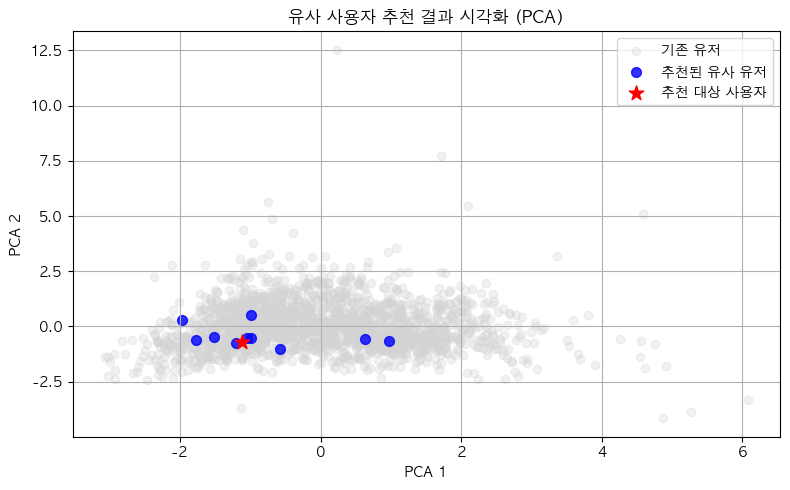

In [200]:
plt.figure(figsize=(8, 5))

# 전체 유저
plt.scatter(X_pca[:-1, 0], X_pca[:-1, 1], c='lightgray', alpha=0.3, label='기존 유저')

# 추천된 유사 사용자
plt.scatter(
    X_pca[recommended_idx, 0],
    X_pca[recommended_idx, 1],
    c='blue',
    label='추천된 유사 유저',
    s=50,
    alpha=0.8
)

# 추천 대상 사용자
plt.scatter(X_pca[-1, 0], X_pca[-1, 1], c='red', label='추천 대상 사용자', s=120, marker='*')

plt.title("유사 사용자 추천 결과 시각화 (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- 훨씬 빠르고 안정적으로 작동하는 것으로 확인
- 아래의 순서로 알고리즘 구현

---

1. 유저 정보 (회원가입 시, 입력) 코드화
2. FAISS로 유사 유저 정보 불러오기
3. 유사 유저들의 여행 기록 불러오기
4. 여행 기록에서 장소 추출
5. 장소와 매칭되는 이미지 가져와서 제공 

In [204]:
import joblib

joblib.dump(pipeline, '../data/VL_CSV/tn_traveller_pipeline.pkl')
joblib.dump(X_all, '../data/VL_CSV/X_all.pkl')

['../data/VL_CSV/X_all.pkl']